In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import datetime
from skimage.io import imread, imsave

from glob import glob
from natsort import natsorted
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm.auto import tqdm
from unet import *

torch.backends.cudnn.benchmark = True

c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


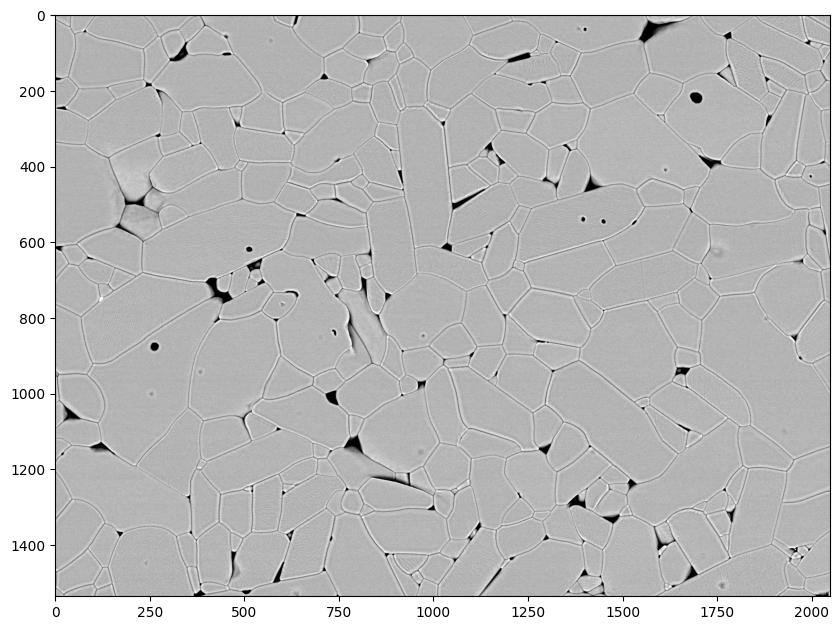

In [2]:
parent_path =r'D:\images\tnia-python-images\\imagesc\\2024_12_19_sem_grain_size_revisit'
im_name = '211122_AM_Al2O3_SE_021.ome.tiff'
label_name = '211122_AM_Al2O3_SE_021_label.tiff'
im = imread(os.path.join(parent_path, im_name))
labels = imread(os.path.join(parent_path, label_name))
plt.figure(figsize=(10, 8))
plt.imshow(im, cmap='gray')

In [3]:
#labels = np.zeros(im.shape, dtype=np.uint8)

In [4]:
#import napari
#viewer = napari.Viewer()
#viewer.add_image(im)
#viewer.add_labels(labels)

In [5]:
im.dtype, labels.dtype
im = im.astype(np.float64)
labels = labels.astype(np.int32)

im.shape, labels.shape

((1536, 2048), (1536, 2048))

In [6]:
labels.max()
labels[labels == 3] =1
labels.max()

2

In [7]:
labels=labels-1

In [8]:
#imsave(os.path.join(parent_path, label_name), labels)

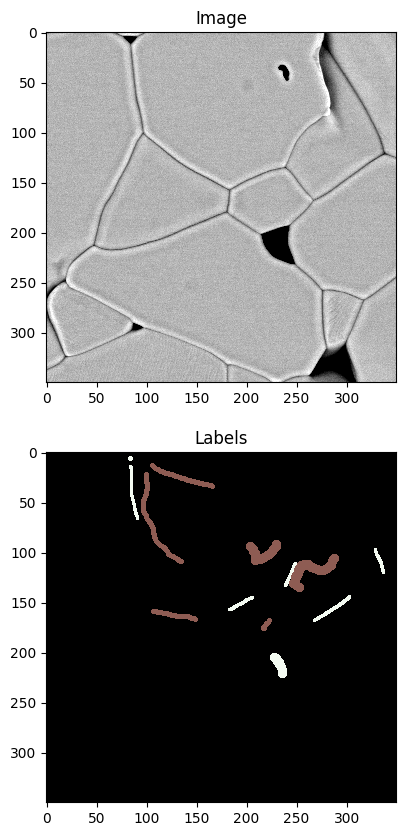

In [9]:
ind =  np.s_[800:1150,500:850]

im_ = im[ind]
labels_ = labels[ind]

from tnia.plotting.plt_helper import imshow_multi2d, random_label_cmap
fig = imshow_multi2d([im_, labels_], ['Image', 'Labels'], 2, 1, 10, 10,colormaps=['gray', random_label_cmap()])

In [10]:
im_.shape, labels_.shape

((350, 350), (350, 350))

In [35]:
import albumentations as A

class SEMDataset(Dataset):
    def __init__(self,
                 X,
                 y,
                 split='train',
                 crop_size=64
                ):
        self.X  = X
        self.y = y
        self.split = split
        self.crop_size = crop_size   
        # use the root dir, split and mask logic to point to the correct files
        #self.mask_files = ... # load mask files into sorted list
        #self.raw_files = ... # load raw files into sorted list
                
    def __len__(self):
        return self.X.shape[0]
    
    def augment_data(self, raw, mask):
        
        transform = A.Compose([
              A.RandomCrop(width=self.crop_size, height=self.crop_size),
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5)
            ])

        transformed = transform(image=raw, mask=mask)

        raw, mask = transformed['image'], transformed['mask']
       
        return raw, mask
       
    def __getitem__(self, idx):
        
        raw = self.X[idx,:, :] # load raw to numpy array
        mask = self.y[idx, :, :] # load mask to numpy array
        
        # if training, run augmentations
        #if self.split == 'train':
        raw, mask = self.augment_data(raw, mask)
       
        #mask = (fg != 0).astype(np.float32)

        # add channel dim for network
        raw = np.expand_dims(raw, axis=0)
        raw = raw.astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        return raw, mask

In [36]:
im_.shape, labels_.shape

((100, 350, 350), (100, 350, 350))

In [37]:
im_.shape, labels_.shape
im_ = np.tile(im_, (10,1,1))
labels_ = np.tile(labels_, (10,1,1))

In [38]:

# add channel dim for network
#im_ = np.expand_dims(im_, axis=0)
#labels_ = np.expand_dims(labels_, axis=0)
train_dataset = SEMDataset(im_, labels_, crop_size=128)
val_dataset = SEMDataset(im_, labels_, split='val', crop_size=128)
test_dataset = SEMDataset(im_, labels_, split='test', crop_size=128)    

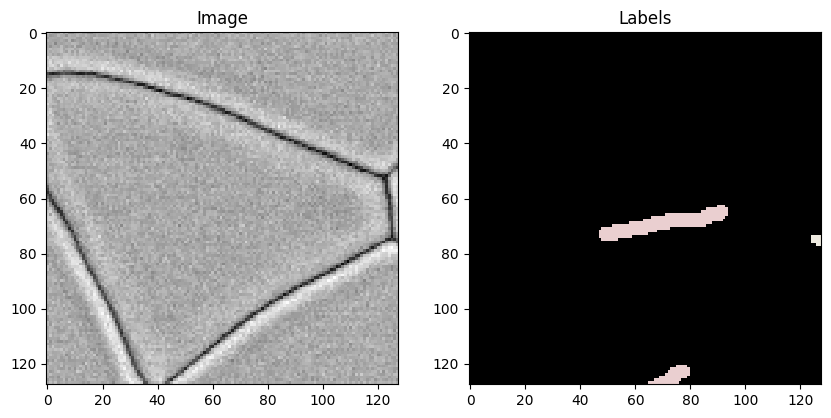

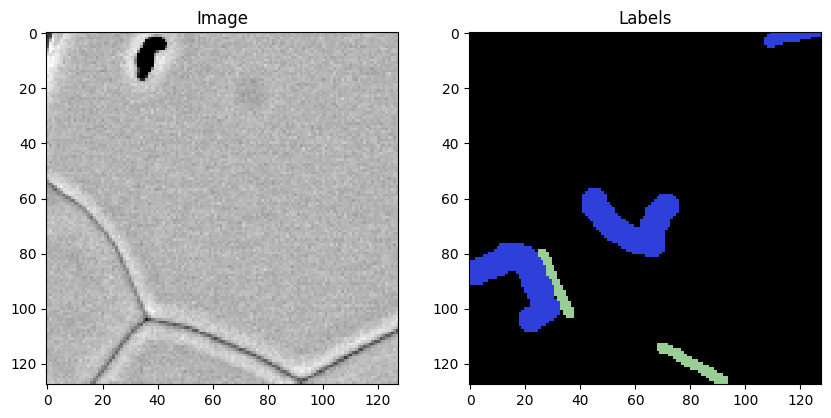

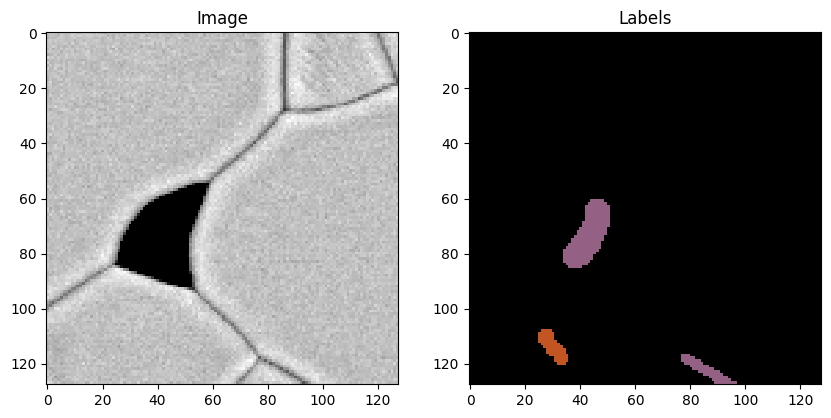

In [49]:
# visualize random batch

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])

raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])
 
raw, mask = train_dataset[random.randrange(len(train_dataset))]
fig = imshow_multi2d([raw[0], mask[0]], ['Image', 'Labels'], 1, 2, 10, 10,colormaps=['gray', random_label_cmap()])

In [50]:
type(raw)

numpy.ndarray

In [40]:
'''
raw, mask = train_dataset[random.randrange(len(train_dataset))]

net_t = raw
fovs = []
d_factors = [[2,2],[2,2]]

net = UNet(in_channels=1,
           num_fmaps=6,
           fmap_inc_factors=2,
           downsample_factors=d_factors,
           padding='same'
          )

for level in range(len(d_factors)+1):
    fov_tmp, _ = net.rec_fov(level , (1, 1), 1)
    fovs.append(fov_tmp[0])

fig=plt.figure(figsize=(5, 5))
colors = ["yellow", "red", "green"]

plt.imshow(np.squeeze(raw), cmap='gray')

for idx, fov_t in enumerate(fovs):
    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))
    xmin = raw.shape[1]/2 - fov_t/2
    xmax = raw.shape[1]/2 + fov_t/2
    ymin = raw.shape[1]/2 - fov_t/2
    ymax = raw.shape[1]/2 + fov_t/2
    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)
    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)
    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)
    plt.vlines(xmax, ymin, ymax, color=colors[idx], lw=3)
plt.show()
'''

'\nraw, mask = train_dataset[random.randrange(len(train_dataset))]\n\nnet_t = raw\nfovs = []\nd_factors = [[2,2],[2,2]]\n\nnet = UNet(in_channels=1,\n           num_fmaps=6,\n           fmap_inc_factors=2,\n           downsample_factors=d_factors,\n           padding=\'same\'\n          )\n\nfor level in range(len(d_factors)+1):\n    fov_tmp, _ = net.rec_fov(level , (1, 1), 1)\n    fovs.append(fov_tmp[0])\n\nfig=plt.figure(figsize=(5, 5))\ncolors = ["yellow", "red", "green"]\n\nplt.imshow(np.squeeze(raw), cmap=\'gray\')\n\nfor idx, fov_t in enumerate(fovs):\n    print("Field of view at depth {}: {:3d} (color: {})".format(idx+1, fov_t, colors[idx]))\n    xmin = raw.shape[1]/2 - fov_t/2\n    xmax = raw.shape[1]/2 + fov_t/2\n    ymin = raw.shape[1]/2 - fov_t/2\n    ymax = raw.shape[1]/2 + fov_t/2\n    plt.hlines(ymin, xmin, xmax, color=colors[idx], lw=3)\n    plt.hlines(ymax, xmin, xmax, color=colors[idx], lw=3)\n    plt.vlines(xmin, ymin, ymax, color=colors[idx], lw=3)\n    plt.vlines(xm

In [41]:
def model_step(model, loss_fn, optimizer, feature, label, activation, train_step=True):
    
    # zero gradients if training
    if train_step:
        optimizer.zero_grad()
    
    # forward
    logits = model(feature)
    
    label=torch.squeeze(label,1)
        
    # final activation
    predicted = activation(logits)

    # pass through loss
    loss_value = loss_fn(input=predicted, target=label)
    
    # backward if training mode
    if train_step:
        loss_value.backward()
        optimizer.step()

    outputs = {
        'pred': predicted,
        'logits': logits,
    }
    
    return loss_value, outputs

In [62]:
def train(train_loader, val_loader, net, loss_fn, activation, optimizer, dtype):

    # set train flags, initialize step
    net.train() 
    loss_fn.train()
    step = 0

    with tqdm(total=training_steps) as pbar:
        while step < training_steps:
            # reset data loader to get random augmentations
            np.random.seed()
            tmp_loader = iter(train_loader)
            for feature, label in tmp_loader:
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                loss_value, pred = model_step(net, loss_fn, optimizer, feature, label, activation)
                writer.add_scalar('loss',loss_value.cpu().detach().numpy(),step)
                step += 1
                pbar.update(1)
                if step % 100 == 0:
                    net.eval()
                    tmp_val_loader = iter(val_loader)
                    acc_loss = []
                    for feature, label in tmp_val_loader:                    
                        label = label.type(dtype)
                        label = label.to(device)
                        feature = feature.to(device)
                        loss_value, _ = model_step(net, loss_fn, optimizer, feature, label, activation, train_step=False)
                        acc_loss.append(loss_value.cpu().detach().numpy())
                    writer.add_scalar('val_loss',np.mean(acc_loss),step)
                    net.train()

                    print(np.mean(acc_loss))

In [43]:
activation = torch.nn.Softmax(dim=1)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=-1)
dtype = torch.LongTensor

d_factors = [[2,2],[2,2],[2,2]]
in_channels=1
num_fmaps=32
fmap_inc_factors=3
padding='same'
final_kernel_size=1
out_channels = 2

unet = UNet(
        in_channels=in_channels,
        num_fmaps=num_fmaps,
        fmap_inc_factors=fmap_inc_factors,
        downsample_factors=d_factors,
        padding=padding)

final_conv = torch.nn.Conv2d(
    in_channels=num_fmaps,
    out_channels=out_channels,
    kernel_size=final_kernel_size)

net = torch.nn.Sequential(unet, final_conv)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = net.to(device)
loss_fn = loss_fn.to(device)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(logdir)

In [63]:
train_batch_size = 4 
test_batch_size = 1

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# make dataloaders
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size)

training_steps = 5000

train(train_loader, val_loader, net, loss_fn, activation, optimizer, dtype)
#tmp_loader = iter(train_loader)
#for feature, label in tmp_loader:
#    print(feature.shape, label.shape)
#    label.to(device)

  2%|▏         | 107/5000 [00:08<26:43,  3.05it/s]

nan


  4%|▍         | 207/5000 [00:17<25:49,  3.09it/s]

nan


  6%|▌         | 307/5000 [00:25<24:51,  3.15it/s]

nan


  8%|▊         | 403/5000 [00:34<34:58,  2.19it/s]

nan


 10%|█         | 503/5000 [00:42<35:19,  2.12it/s]

nan


 12%|█▏        | 604/5000 [00:51<35:29,  2.06it/s]

nan


 14%|█▍        | 704/5000 [00:59<32:40,  2.19it/s]

nan


 16%|█▌        | 804/5000 [01:08<34:13,  2.04it/s]

nan


 18%|█▊        | 904/5000 [01:17<33:18,  2.05it/s]

nan


 20%|██        | 1004/5000 [01:26<32:56,  2.02it/s]

nan


 22%|██▏       | 1104/5000 [01:35<32:19,  2.01it/s]

nan


 24%|██▍       | 1204/5000 [01:44<31:59,  1.98it/s]

nan


 26%|██▌       | 1304/5000 [01:54<30:58,  1.99it/s]

nan


 28%|██▊       | 1404/5000 [02:02<29:47,  2.01it/s]

nan


 30%|███       | 1508/5000 [02:11<19:03,  3.05it/s]

nan


 32%|███▏      | 1604/5000 [02:20<28:29,  1.99it/s]

nan


 34%|███▍      | 1704/5000 [02:29<26:16,  2.09it/s]

nan


 36%|███▌      | 1804/5000 [02:37<25:55,  2.05it/s]

nan


 38%|███▊      | 1905/5000 [02:46<17:28,  2.95it/s]

nan


 40%|████      | 2005/5000 [02:55<16:39,  3.00it/s]

nan


 42%|████▏     | 2105/5000 [03:03<16:23,  2.94it/s]

nan


 44%|████▍     | 2205/5000 [03:12<15:43,  2.96it/s]

nan


 46%|████▌     | 2305/5000 [03:20<15:19,  2.93it/s]

nan


 48%|████▊     | 2405/5000 [03:29<14:21,  3.01it/s]

nan


 50%|█████     | 2505/5000 [03:37<13:54,  2.99it/s]

nan


 52%|█████▏    | 2605/5000 [03:46<13:16,  3.01it/s]

nan


 54%|█████▍    | 2705/5000 [03:54<12:49,  2.98it/s]

nan


 56%|█████▌    | 2806/5000 [04:03<12:15,  2.98it/s]

nan


 58%|█████▊    | 2907/5000 [04:12<11:45,  2.97it/s]

nan


 60%|██████    | 3007/5000 [04:20<11:11,  2.97it/s]

nan


 62%|██████▏   | 3107/5000 [04:28<10:16,  3.07it/s]

nan


 64%|██████▍   | 3203/5000 [04:37<14:28,  2.07it/s]

nan


 66%|██████▌   | 3307/5000 [04:46<09:35,  2.94it/s]

nan


 68%|██████▊   | 3403/5000 [04:54<12:23,  2.15it/s]

nan


 70%|███████   | 3507/5000 [05:03<08:14,  3.02it/s]

nan


 72%|███████▏  | 3607/5000 [05:12<08:06,  2.86it/s]

nan


 74%|███████▍  | 3707/5000 [05:20<07:27,  2.89it/s]

nan


 76%|███████▌  | 3807/5000 [05:29<06:47,  2.93it/s]

nan


 78%|███████▊  | 3903/5000 [05:38<08:58,  2.04it/s]

nan


 80%|████████  | 4007/5000 [05:47<05:43,  2.89it/s]

nan


 82%|████████▏ | 4107/5000 [05:55<05:03,  2.94it/s]

nan


 84%|████████▍ | 4203/5000 [06:04<06:16,  2.12it/s]

nan


 86%|████████▌ | 4307/5000 [06:12<03:49,  3.03it/s]

nan


 88%|████████▊ | 4403/5000 [06:21<04:35,  2.17it/s]

nan


 90%|█████████ | 4507/5000 [06:29<02:43,  3.01it/s]

nan


 92%|█████████▏| 4603/5000 [06:38<03:15,  2.03it/s]

nan


 94%|█████████▍| 4707/5000 [06:47<01:44,  2.80it/s]

nan


 96%|█████████▌| 4807/5000 [06:56<01:04,  3.01it/s]

nan


 98%|█████████▊| 4904/5000 [07:04<00:45,  2.11it/s]

nan


100%|██████████| 5000/5000 [07:13<00:00, 11.54it/s]

nan


In [52]:

# set train flags, initialize step
net.train() 
loss_fn.train()
step = 0

while step < 10:
    # reset data loader to get random augmentations
    np.random.seed()
    tmp_loader = iter(train_loader)
    for feature, label in tmp_loader:
        print('hello')
        step+=1
        print(step)
        print(dtype)
        print(label.type)
        label = label.type(dtype)
        label = label.to(device)
        
        feature = feature.to(device)
            
        # zero gradients if training
        optimizer.zero_grad()
        
        
        # forward
        logits = net(feature)
        
        label=torch.squeeze(label,1)
            
        # final activation
        predicted = activation(logits)

        print('made it to predicted')
        
        # pass through loss
        loss_value = loss_fn(input=predicted, target=label)
        '''
        # backward if training mode
        if train_step:
            loss_value.backward()
            optimizer.step()

        outputs = {
            'pred': predicted,
            'logits': logits,
        }
    
        
        
        loss_value, pred = model_step(net, loss_fn, optimizer, feature, label, activation)
        
        writer.add_scalar('loss',loss_value.cpu().detach().numpy(),step)
        step += 1
        #pbar.update(1)
        if step % 100 == 0:
            net.eval()
            tmp_val_loader = iter(val_loader)
            acc_loss = []
            for feature, label in tmp_val_loader:                    
                label = label.type(dtype)
                label = label.to(device)
                feature = feature.to(device)
                loss_value, _ = model_step(net, loss_fn, optimizer, feature, label, activation, train_step=False)
                acc_loss.append(loss_value.cpu().detach().numpy())
            writer.add_scalar('val_loss',np.mean(acc_loss),step)
            net.train()

            print(np.mean(acc_loss))
        '''

hello
1
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A3A6310720>
made it to predicted
hello
2
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A3A63117B0>
made it to predicted
hello
3
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A3156E72E0>
made it to predicted
hello
4
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A310F861B0>
made it to predicted
hello
5
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A3110B65C0>
made it to predicted
hello
6
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A3110AFD30>
made it to predicted
hello
7
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A3963EF560>
made it to predicted
hello
8
<class 'torch.LongTensor'>
<built-in method type of Tensor object at 0x000002A3A62408B0>
made it to predicted
hello
9
<class 'torch.LongTensor'>
<built-in method type

In [65]:
# Visualize predictions

net.eval()

im.shape
im = im.astype(np.float32)
im_tensor = torch.from_numpy(im).unsqueeze(0).unsqueeze(0).to(device)       
logits=net(im_tensor)
 

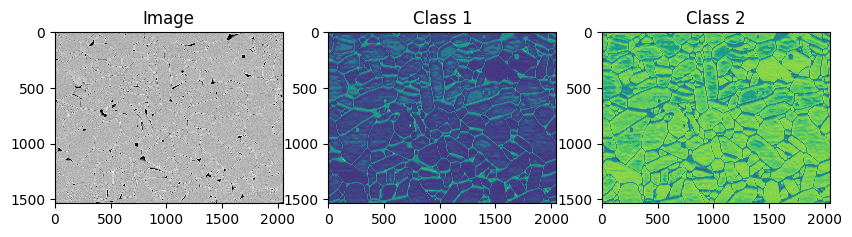

In [67]:
logits.shape
c1 = logits[0,0,:,:].cpu().detach().numpy()
c2 = logits[0,1,:,:].cpu().detach().numpy()

fig = imshow_multi2d([im, c1, c2], ['Image', 'Class 1', 'Class 2'], 1, 3, 10, 10,colormaps=['gray', 'viridis', 'viridis'])

In [68]:
import napari
viewer = napari.Viewer()
viewer.add_image(im)
viewer.add_image(c1)
viewer.add_image(c2)

<Image layer 'c2' at 0x2a3e74d3b80>